# Gene Expression variance analysis - curated gene lists

Cohorts
- ClinGen Haplo-insufficient (HI)
- Non-essential (PMID 25645873)

## Per-gene summary statistics

For every gene \(g\) we first **filter** its variant table to **biallelic SNPs** with
minor-allele frequency (AF) \(\ge 0.01\).
Let the remaining set of variants be
\(\mathcal V_g = \{v_1,\ldots ,v_{N_g}\}\) with

* predicted expression difference
 $(\displaystyle )\Delta_i = \texttt{DELTA}(v_i))$
* allele frequency
  $(f_i = \texttt{AF}(v_i))$.

---

| quantity | formula                                                                                                                                        | code column |
|----------|------------------------------------------------------------------------------------------------------------------------------------------------|-------------|
| **number of SNPs** | $( \text{num\_snps}_g = N_g)$                                                                                                                  | `num_snps` |
| **per-variant cis-variance** | $(\text{VAR\_I}_i = \Delta_i^{\,2}\; 2f_i(1-f_i))$                                                                                             | produced earlier by *variant scoring* script |
| **predicted cis-variance (gene-level)** | $(\operatorname{Var}^{\text{cis}}_g = \sum_{i\in\mathcal V_g}\text{VAR\_I}_i)$                                                                 | `predicted_cis_variance` |
| **mean / median AF** | $(\overline f_g = \frac1{N_g}\sum_i f_i,\qquad \tilde f_g = \operatorname{median}(f_i))$                                                       | `mean_AF`, `median_AF` |
| **mean / median Δ** | $(\overline\Delta_g = \frac1{N_g}\sum_i \Delta_i,\qquad \tilde\Delta_g = \operatorname{median}(\Delta_i))$                                     | `mean_DELTA`, `median_DELTA` |
| **mean / median VAR\_I** | $(\overline{\text{VAR\_I}}_g = \frac1{N_g}\sum_i \text{VAR\_I}_i,\qquad \widetilde{\text{VAR\_I}}_g = \operatorname{median}(\text{VAR\_I}_i))$ | `mean_VAR_I`, `median_VAR_I` |

---

### Notes

* The $(2f(1-f))$ term converts the squared effect $(\Delta^{2})$ to **additive genetic variance** under Hardy–Weinberg equilibrium.

## 1. Load and summarize cis-variance predictions from FlashZoi

In [49]:
# Setup
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
import os
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from sklearn.linear_model import LinearRegression
import pingouin as pg
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

clingen_scored_dir = "/Users/markus/seq2expr-variance/data/output/dataset3/flashzoi_outputs/ClinGen_gene_curation_list"
nonessential_scored_dir = "/Users/markus/seq2expr-variance/data/output/dataset3/flashzoi_outputs/nonessential_ensg"

clingen_cache = "/Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/clingen_summary.tsv"
nonessential_cache = "/Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/nonessential_summary.tsv"

gtex_expr_file = "../../data/initial/GTEx_Analysis_2022-06-06_v10_RNASeQCv2.4.2_gene_median_tpm.gct"

# gtex_sample_expr_file = "../../data/initial/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_tpm.gct.gz"
# sample_annot_file = "../../data/initial/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt"

gene_metrics_vgh = "/Users/markus/seq2expr-variance/data/initial/gene_metrics_vgh_202407.tsv.gz"

In [24]:
def load_variants_summary(
        variants_scored_dir: str,
        cache_file: str,
        min_af: float = 0.01,
        force_reload: bool = False
    ) -> pd.DataFrame:
    """
    Build a per-gene summary table from scored-variant folders.
    variants_scored_dir : str
        Path containing one sub-folder per gene, each with <gene>_variants.tsv.
    cache_file : str
        Where the summary TSV will be cached / read from.
    min_af : float, optional
        Minimum alternate-allele frequency (inclusive) to keep a variant. Filtering the common variants here
    force_reload : bool, optional
        Ignore an existing cache and rebuild the summary
    """
    if os.path.exists(cache_file) and not force_reload:
        var_df = pd.read_csv(cache_file, sep="\t")
        print(f"Loaded cached gene summary table: {cache_file}")
        return var_df

    records = []
    for folder in glob.glob(os.path.join(variants_scored_dir, "*")):
        gene_id  = os.path.basename(folder)
        var_file = os.path.join(folder, f"{gene_id}_variants.tsv")
        if not os.path.isfile(var_file):
            continue

        df = pd.read_csv(var_file, sep="\t")
        df.columns = df.columns.str.upper()

        # ── AF filtering ───────────────────────────────────────────
        if "AF" not in df.columns:
            continue  # skip malformed tables
        df["AF"] = pd.to_numeric(df["AF"], errors="coerce")
        before = len(df)
        df = df[df["AF"] >= min_af].reset_index(drop=True)
        after = len(df)
        # Uncomment for debugging:
        # print(f"{gene_id}: kept {after}/{before} variants with AF ≥ {min_af}")

        if df.empty or not {"VAR_I", "DELTA"}.issubset(df.columns):
            continue

        records.append({
            "gene_id": gene_id,
            "predicted_cis_variance": df["VAR_I"].sum(),
            "num_snps": len(df),
            "mean_AF": df["AF"].mean(),
            "median_AF": df["AF"].median(),
            "mean_DELTA": df["DELTA"].mean(),
            "median_DELTA": df["DELTA"].median(),
            "mean_VAR_I": df["VAR_I"].mean(),
            "median_VAR_I": df["VAR_I"].median()
        })

    var_df = pd.DataFrame(records)
    var_df.to_csv(cache_file, sep="\t", index=False)
    print(f"Saved gene summary to: {cache_file}")
    return var_df

var_df_clingen = load_variants_summary(clingen_scored_dir, clingen_cache,
                                       min_af=0.01, force_reload=True)
var_df_nonessential = load_variants_summary(nonessential_scored_dir, nonessential_cache,
                                            min_af=0.01, force_reload=True)

print("ClinGen:", var_df_clingen.shape)
print(var_df_clingen.head())
print("Non-essential:", var_df_nonessential.shape)
print(var_df_nonessential.head())

Saved gene summary to: /Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/clingen_summary.tsv
Saved gene summary to: /Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/nonessential_summary.tsv
ClinGen: (314, 9)
           gene_id  predicted_cis_variance  num_snps   mean_AF  median_AF  \
0  ENSG00000015171              107.976299      1993  0.224439   0.083773   
1  ENSG00000089225               91.428603      2875  0.176341   0.078200   
2  ENSG00000182774            38175.965101      2685  0.164024   0.065789   
3  ENSG00000096696               31.438518      2848  0.216798   0.123680   
4  ENSG00000179348                0.279142      2364  0.198366   0.053371   

   mean_DELTA  median_DELTA  mean_VAR_I  median_VAR_I  
0   -0.552997     -0.552997    0.054178      0.035492  
1   -0.410008     -0.410007    0.031801      0.023503  
2    8.777559      8.777374   14.218237      8.993818  
3   -0.216422     -0.216342    0.011039      0.009602  
4    0.025248     

## 2. Distribution overview of gene-level predicted variance

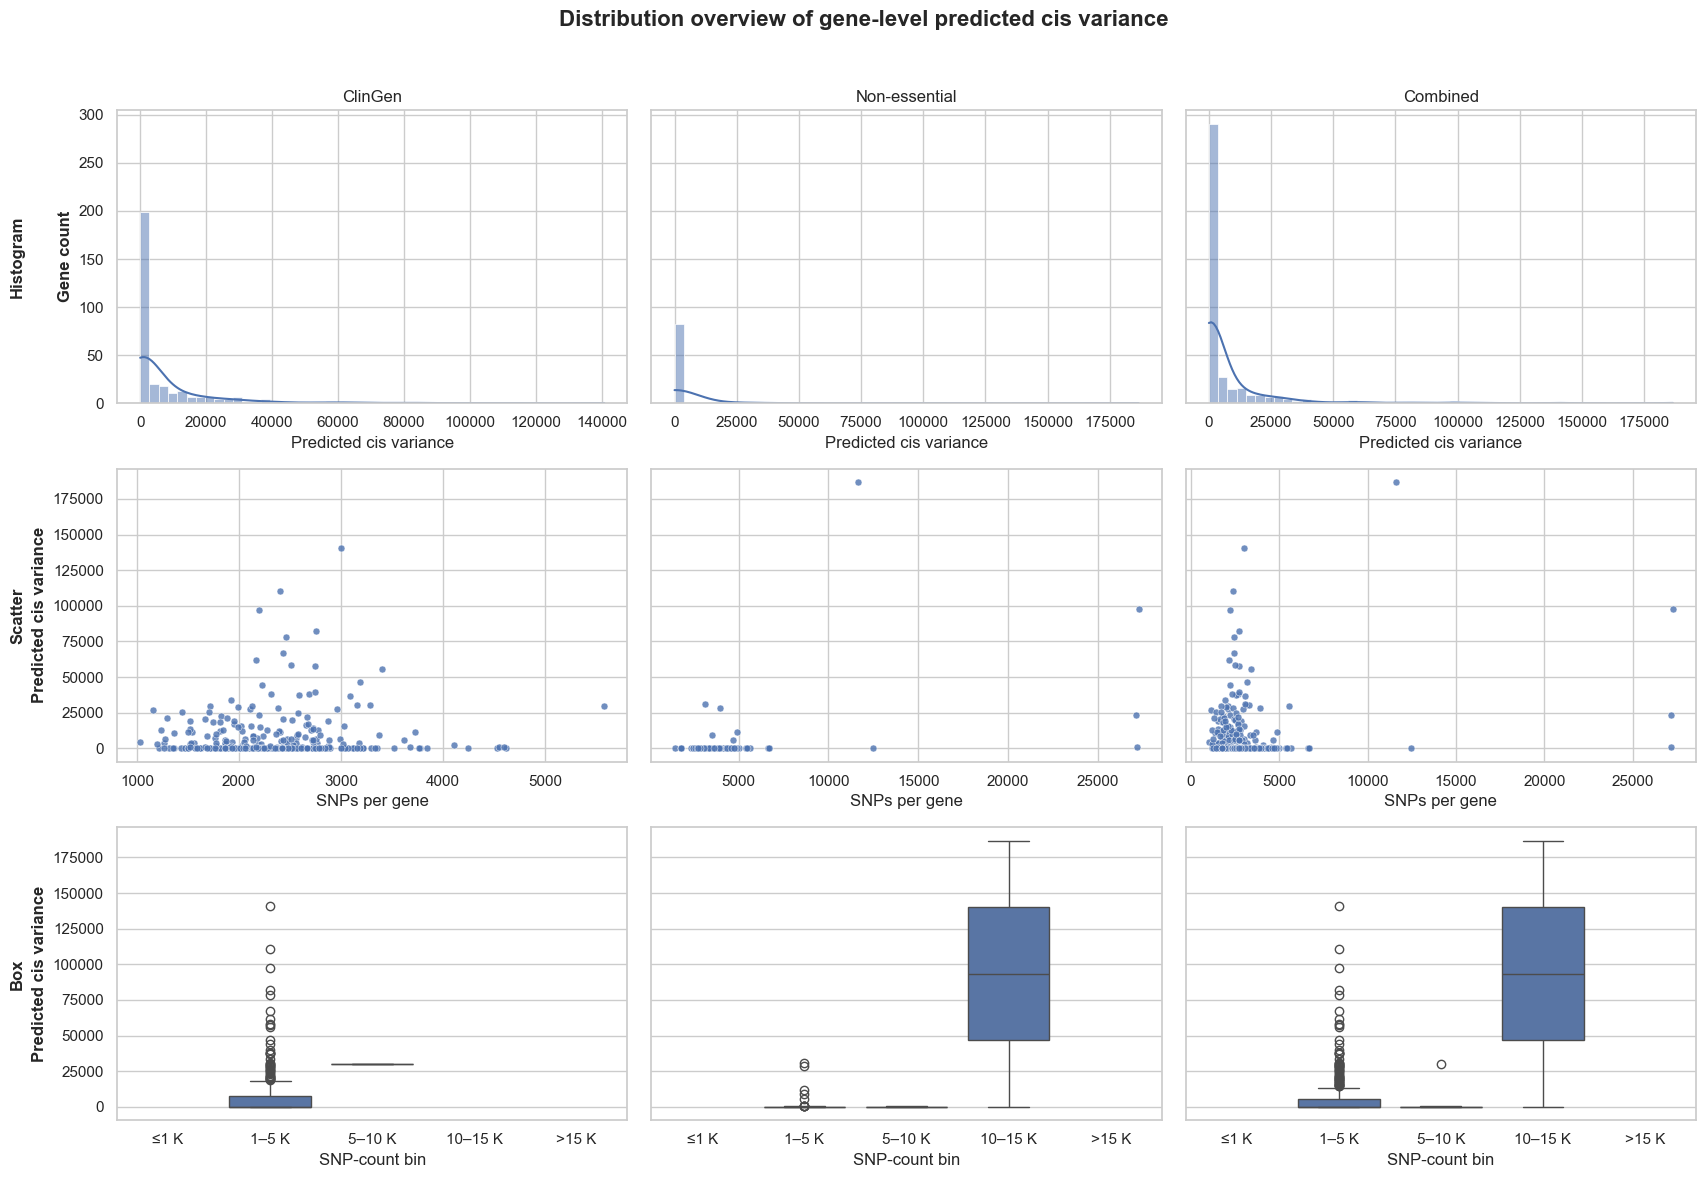

In [40]:
sns.set_theme(style="whitegrid")

var_df_clingen      = var_df_clingen.copy()
var_df_nonessential = var_df_nonessential.copy()
var_df_clingen["cohort"]      = "ClinGen"
var_df_nonessential["cohort"] = "Non-essential"
var_df_all = pd.concat([var_df_clingen, var_df_nonessential], ignore_index=True)
var_df_all["cohort"] = "Combined"

cohort_dfs = {
    "ClinGen"        : var_df_clingen,
    "Non-essential"  : var_df_nonessential,
    "Combined"       : var_df_all
}

fig, axes = plt.subplots(3, 3, figsize=(17, 12), sharey="row")
plot_types = ["Histogram", "Scatter", "Box"]

for col, (cohort_name, df) in enumerate(cohort_dfs.items()):
    # 1) histogram of cis variance
    sns.histplot(df["predicted_cis_variance"],
                 bins=50, kde=True, ax=axes[0, col])
    axes[0, col].set_title(f"{cohort_name}")
    axes[0, col].set_xlabel("Predicted cis variance")
    axes[0, col].set_ylabel("Gene count" if col == 0 else "")

    # 2) scatter SNP count vs cis variance
    sns.scatterplot(data=df, x="num_snps", y="predicted_cis_variance",
                    ax=axes[1, col], s=25, alpha=0.8)
    axes[1, col].set_xlabel("SNPs per gene")
    axes[1, col].set_ylabel("Predicted cis variance" if col == 0 else "")

    # 3) cis variance binned by SNP count
    tmp = df.copy()
    tmp["snp_bin"] = pd.cut(tmp["num_snps"],
                            bins=[0, 1000, 5000, 10000, 15000, 20000],
                            labels=["≤1 K", "1–5 K", "5–10 K", "10–15 K", ">15 K"])
    sns.boxplot(data=tmp, x="snp_bin", y="predicted_cis_variance",
                ax=axes[2, col])
    axes[2, col].set_xlabel("SNP-count bin")
    axes[2, col].set_ylabel("Predicted cis variance" if col == 0 else "")

for row, label in enumerate(plot_types):
    axes[row, 0].set_ylabel(axes[row, 0].get_ylabel(), weight="bold")
    axes[row, 0].annotate(label, xy=(-0.18, 0.5),
                          xycoords="axes fraction", va="center",
                          ha="right", fontsize=12, weight="bold",
                          rotation=90)

fig.suptitle("Distribution overview of gene-level predicted cis variance",
             fontsize=16, weight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 3. Distribution analysis

### 3.1 Basic stats

In [41]:
metric   = "predicted_cis_variance"
hi_vals  = var_df_clingen[metric]
ne_vals  = var_df_nonessential[metric]

u, p_u   = mannwhitneyu(hi_vals, ne_vals, alternative="two-sided")
d        = pg.compute_effsize(hi_vals, ne_vals, eftype="cohen")
auc      = pg.compute_effsize(hi_vals, ne_vals, eftype="AUC")
cliff    = 2 * auc - 1   # convert AUC → Cliff’s δ

print(f"Mann–Whitney U p = {p_u:.2e}")
print(f"Cohen's d        = {d:+.2f}") # The shift is only 0.18 SD—barely past the conventional “small” threshold (0.20)
print(f"Cliff's delta    = {cliff:+.2f}") # If we pick one random HI gene and one random non-essential gene, the HI gene’s cis-variance is higher ≈ 55 % of the time (δ = 0 ↔ 50 %; small ≈ 0.15).

# import inspect, pingouin as pg
# print(inspect.getsource(pg.compute_effsize))

Mann–Whitney U p = 1.32e-05
Cohen's d        = +0.18
Cliff's delta    = +0.10


Strong p value rejecton, two cohorts do not share the same distribution of predicted cis-variance.

### 3.2 Log-fold change vs background

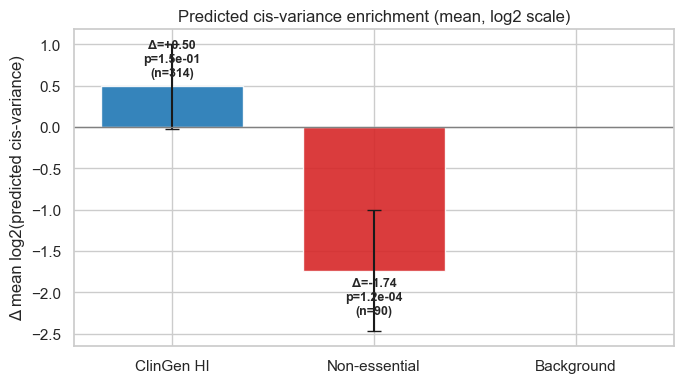

In [42]:
def bar_against_bg_mean(df_subset, label, ax, color,
                        bg_df=var_df_all, n_boot=5000):
    """
    Draw one bar showing Δ-mean log₂(predicted cis-variance) for *df_subset*
    relative to *bg_df*.  Error bar = bootstrap 95 % CI of that shift.
    """
    bg_log     = np.log2(bg_df["predicted_cis_variance"] + 1e-6)
    subset_log = np.log2(df_subset["predicted_cis_variance"] + 1e-6)

    mean_shift = subset_log.mean() - bg_log.mean()

    ci_low, ci_high = pg.compute_bootci(subset_log, func=np.mean,
                                        n_boot=n_boot, confidence=0.95)
    ci_low_shift, ci_high_shift = ci_low - bg_log.mean(), ci_high - bg_log.mean()

    ax.bar(label, mean_shift, color=color, width=0.7,
           yerr=[[mean_shift - ci_low_shift],
                 [ci_high_shift - mean_shift]],
           capsize=5, alpha=0.9)

    # Welch t-test on the same log₂ values
    p_val = ttest_ind(subset_log, bg_log, equal_var=False).pvalue

    ax.text(label, mean_shift + 0.08*np.sign(mean_shift or 1),
            f"Δ={mean_shift:+.2f}\n"
            f"p={p_val:.1e}\n"
            f"(n={len(subset_log)})",
            ha="center", va="bottom" if mean_shift>0 else "top",
            fontsize=9, weight="bold")

fig, ax = plt.subplots(figsize=(7, 4))

bar_against_bg_mean(var_df_clingen,      "ClinGen HI",   ax, "#1f77b4")
bar_against_bg_mean(var_df_nonessential, "Non-essential", ax, "#d62728")
ax.bar("Background", 0, color="lightgray", width=0.7, alpha=0.6)

ax.axhline(0, color="gray", lw=1)
ax.set_ylabel("Δ mean log2(predicted cis-variance)")
ax.set_title("Predicted cis-variance enrichment (mean, log2 scale)")
plt.tight_layout()
plt.show()

### 3.3 Adjust for a confounder with ANCOVA


Replace the pair-wise test with a single model so we can adjust for things like gene length or GC %. The cohort[T.HI] coefficient tells us whether HI genes still carry higher cis-variance after accounting for SNP burden.


In [43]:
var_df_all["cohort"] = np.where(var_df_all["cohort"]=="ClinGen", "HI", "NonEss")

model = smf.ols("np.log10(predicted_cis_variance+1e-6) ~ cohort + num_snps", data=var_df_all).fit()
print(model.summary())

                                       OLS Regression Results                                      
Dep. Variable:     np.log10(predicted_cis_variance + 1e-6)   R-squared:                       0.004
Model:                                                 OLS   Adj. R-squared:                  0.001
Method:                                      Least Squares   F-statistic:                     1.473
Date:                                     Fri, 27 Jun 2025   Prob (F-statistic):              0.226
Time:                                             13:24:09   Log-Likelihood:                -699.18
No. Observations:                                      404   AIC:                             1402.
Df Residuals:                                          402   BIC:                             1410.
Df Model:                                                1                                         
Covariance Type:                                 nonrobust                                         


SNP burden per gene is not a useful predictor of predicted cis-variance

### 3.5 Rank-enrichment across the genome

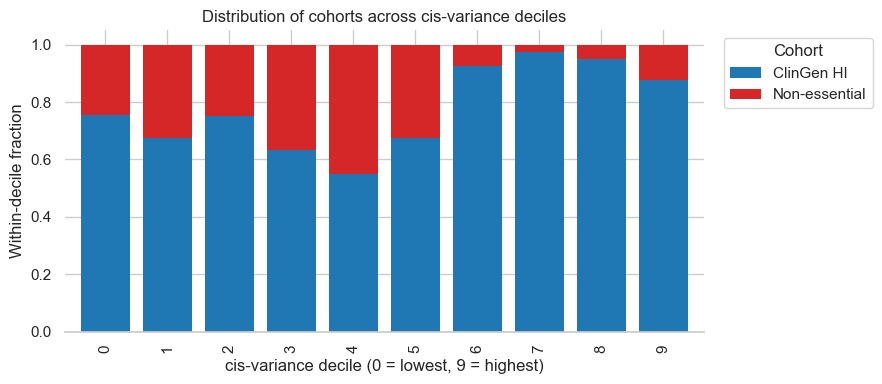

In [45]:
var_df_all_dec = pd.concat([
    var_df_clingen     .assign(cohort="ClinGen HI"),
    var_df_nonessential.assign(cohort="Non-essential")
], ignore_index=True)

# put every gene into a cis-variance decile (0 = lowest 10 %, 9 = top 10 %)
var_df_all_dec["decile"] = pd.qcut(
    var_df_all_dec["predicted_cis_variance"],
    10, labels=False, duplicates="drop"
)

# then we count genes per (decile, cohort) → convert to within-decile fractions
dec_counts = (var_df_all_dec
              .groupby(["decile", "cohort"])
              .size()
              .unstack(fill_value=0))
dec_frac   = dec_counts.div(dec_counts.sum(axis=1), axis=0)

# a stacked bar plot
palette = ["#1f77b4", "#d62728"]
ax = dec_frac.plot(kind="bar", stacked=True, width=0.8,
                   figsize=(9, 4), color=palette, edgecolor="none")

ax.set_ylabel("Within-decile fraction")
ax.set_xlabel("cis-variance decile (0 = lowest, 9 = highest)")
ax.set_title("Distribution of cohorts across cis-variance deciles")
ax.legend(title="Cohort", bbox_to_anchor=(1.02, 1), loc="upper left")
sns.despine(left=True)
plt.tight_layout()
plt.show()

- haplo-insufficient (HI) genes tend toward higher predicted cis‐variance
- all parametric and non-parametric effect sizes are in the small band

## 4. Correlation exploring

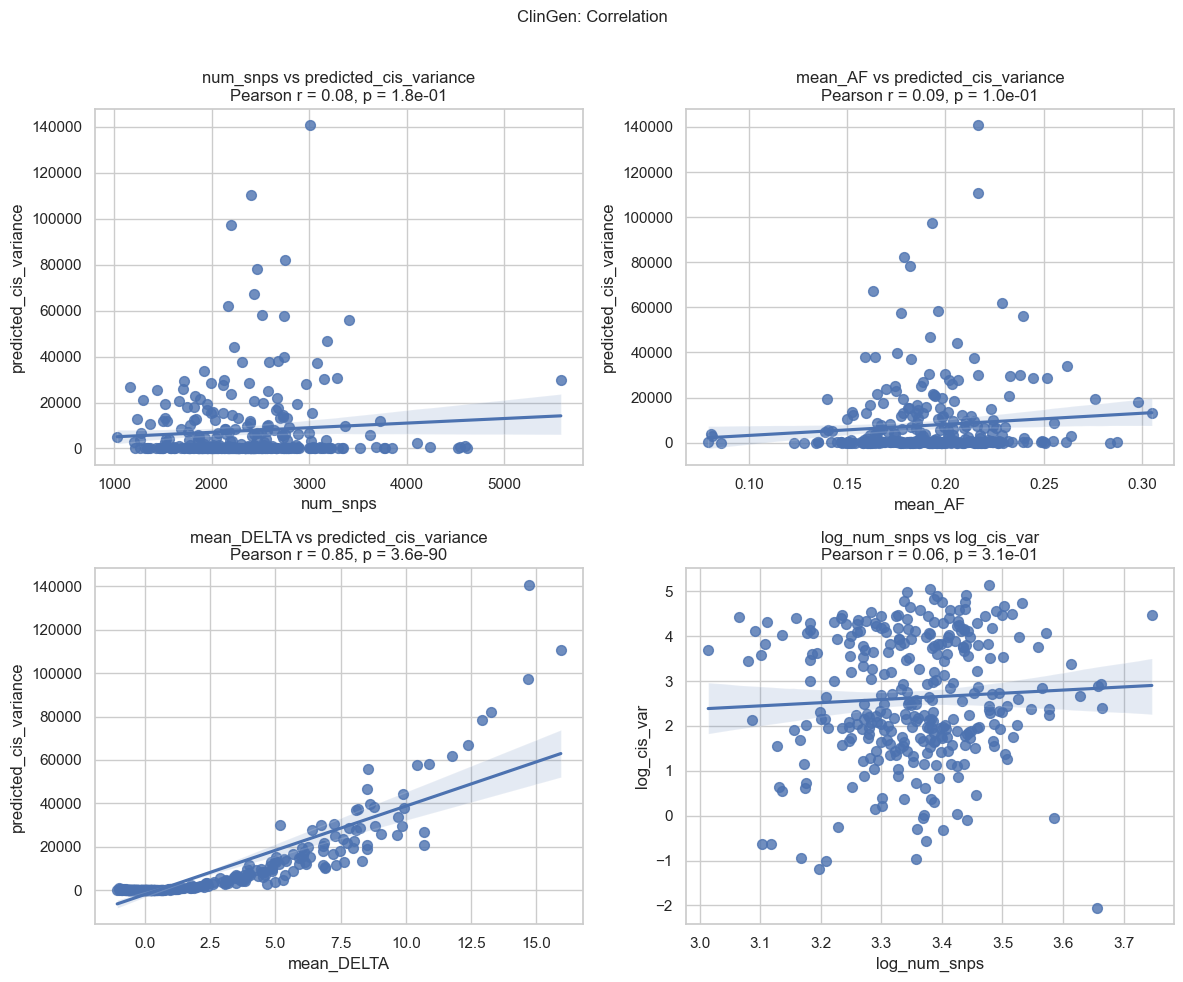

,X,Y,Pearson_r,Pearson_p,Spearman_r,Spearman_p
0,num_snps,predicted_cis_variance,0.076,0.182,0.072,0.200
1,mean_AF,predicted_cis_variance,0.093,0.100,0.085,0.132
2,mean_DELTA,predicted_cis_variance,0.853,0.000,0.765,0.000
3,log_num_snps,log_cis_var,0.057,0.312,0.072,0.200


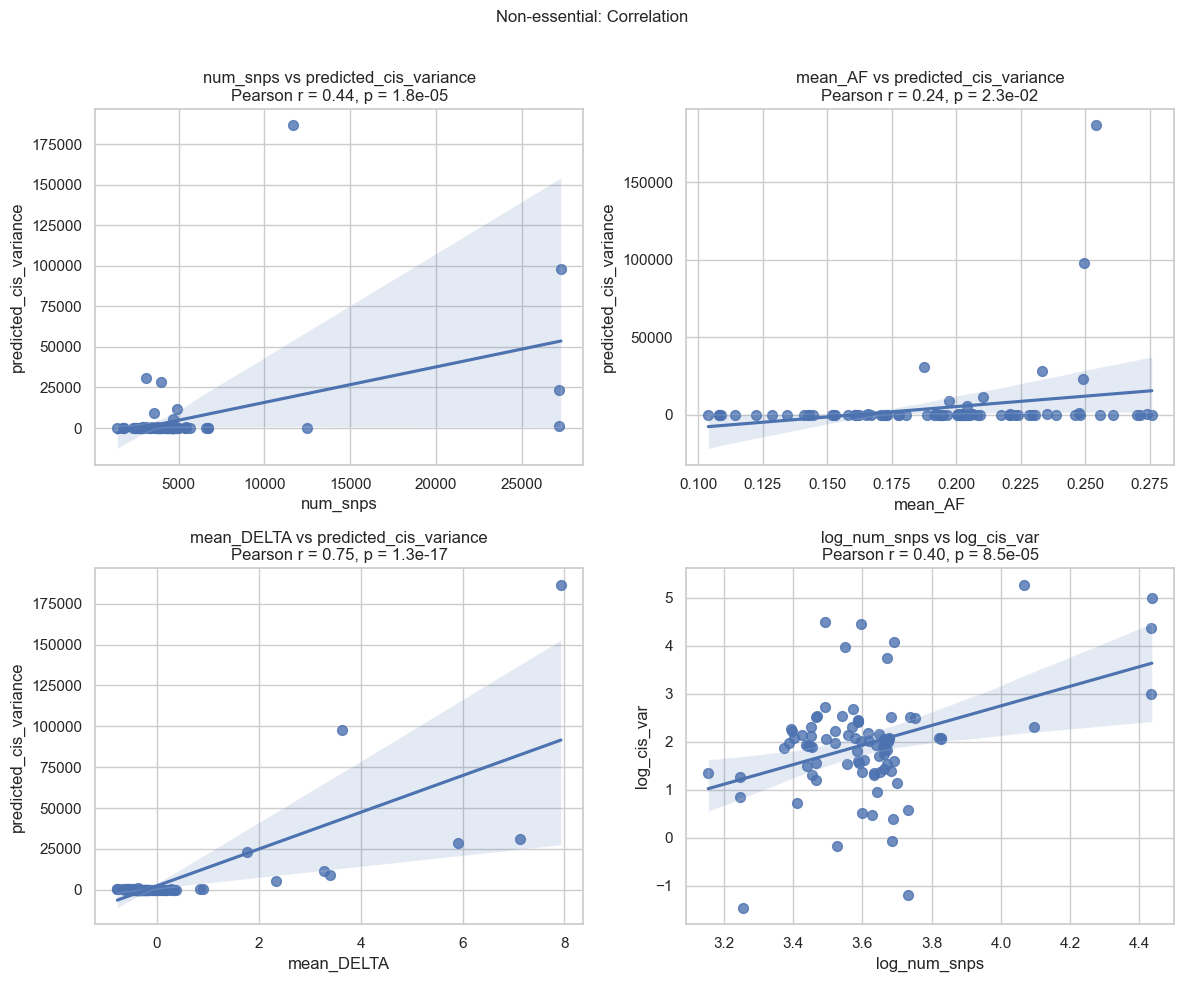

,X,Y,Pearson_r,Pearson_p,Spearman_r,Spearman_p
0,num_snps,predicted_cis_variance,0.435,0.000,0.119,0.264
1,mean_AF,predicted_cis_variance,0.240,0.023,0.370,0.000
2,mean_DELTA,predicted_cis_variance,0.752,0.000,-0.249,0.018
3,log_num_snps,log_cis_var,0.402,0.000,0.119,0.264


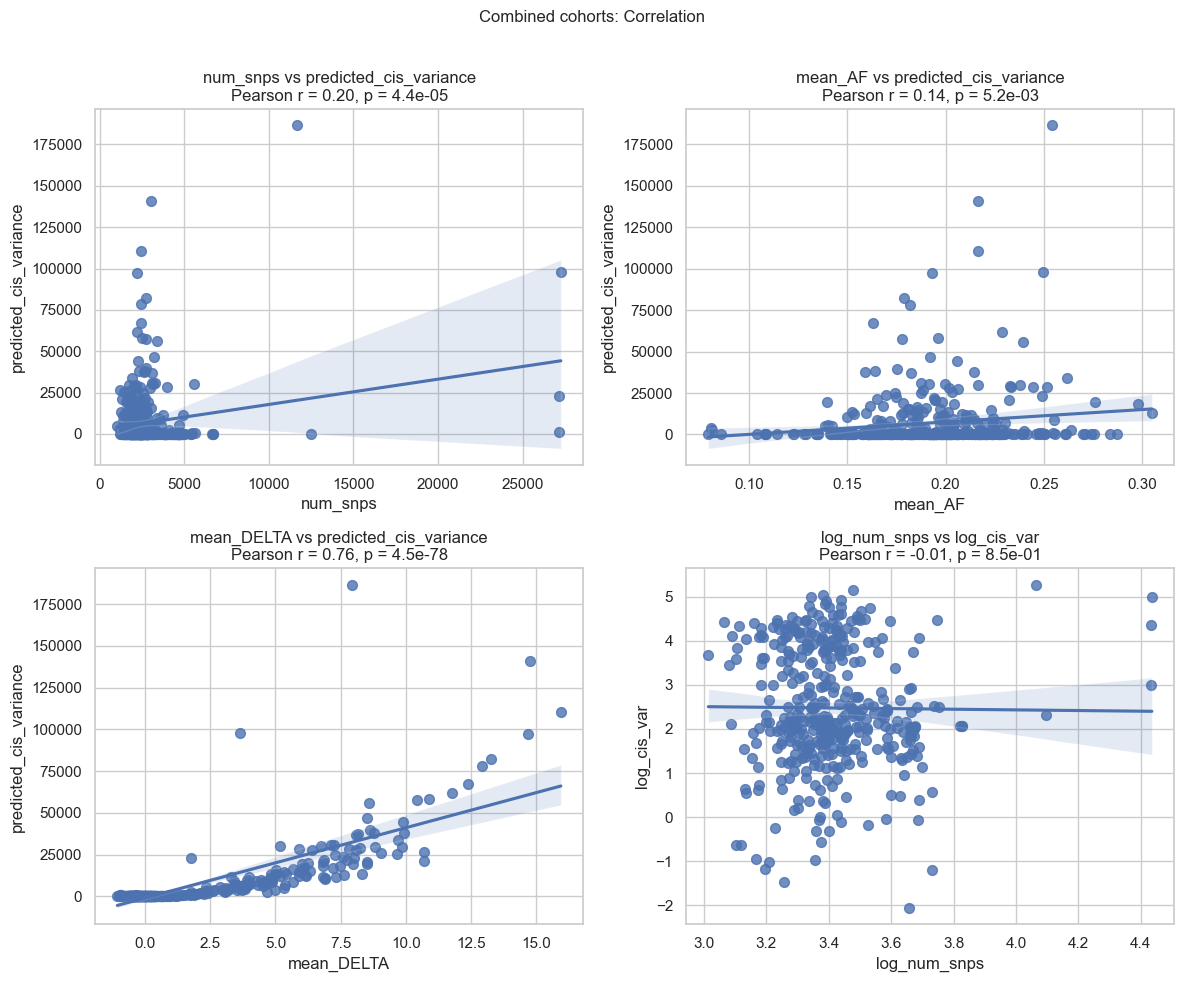

,X,Y,Pearson_r,Pearson_p,Spearman_r,Spearman_p
0,num_snps,predicted_cis_variance,0.202,0.000,-0.042,0.396
1,mean_AF,predicted_cis_variance,0.139,0.005,0.133,0.008
2,mean_DELTA,predicted_cis_variance,0.763,0.000,0.626,0.000
3,log_num_snps,log_cis_var,-0.010,0.848,-0.042,0.396


In [46]:
sns.set_theme(style="whitegrid")

def add_log_columns(df: pd.DataFrame, base: int = 10) -> pd.DataFrame:
    """
    Adds log_cis_var and log_num_snps to *df*.
    Set base=2 for log₂, base=10 for log₁₀ (default).
    """
    log_fn = np.log2 if base == 2 else np.log10
    df["log_cis_var"] = log_fn(df["predicted_cis_variance"] + 1e-6)
    df["log_num_snps"] = log_fn(df["num_snps"] + 1e-6)
    return df

correlations = [
    ("num_snps",      "predicted_cis_variance"),
    ("mean_AF",       "predicted_cis_variance"),
    ("mean_DELTA",    "predicted_cis_variance"),
    ("log_num_snps",  "log_cis_var"),
]

# ──-─  table + plots per cohort
def correlation_overview(df: pd.DataFrame, title_prefix: str, log_base: int = 10):
    df = add_log_columns(df.copy(), base=log_base)

    # ---- correlation table
    corr_rows = []
    for x, y in correlations:
        pearson_r, p_p = pearsonr(df[x], df[y])
        spearman_r, p_s = spearmanr(df[x], df[y])
        corr_rows.append(
            dict(X=x, Y=y,
                 Pearson_r=pearson_r, Pearson_p=p_p,
                 Spearman_r=spearman_r, Spearman_p=p_s)
        )
    corr_df = pd.DataFrame(corr_rows)

    # ---- scatter-with-regression plots (2×2 grid)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, (x, y) in enumerate(correlations):
        sns.regplot(data=df, x=x, y=y, ax=axes[i],
                    scatter_kws={"s": 50, "alpha": 0.8})
        r, p = pearsonr(df[x], df[y])
        axes[i].set_title(f"{x} vs {y}\nPearson r = {r:.2f}, p = {p:.1e}")
        axes[i].set_xlabel(x)
        axes[i].set_ylabel(y)

    fig.suptitle(f"{title_prefix}: Correlation", fontsize=12)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    display(corr_df.style.set_caption(f"{title_prefix}: Correlation table")
                         .format(precision=3))
    return corr_df


var_df_clingen      = var_df_clingen.copy()
var_df_nonessential = var_df_nonessential.copy()
var_df_clingen["cohort"]      = "ClinGen"
var_df_nonessential["cohort"] = "Nonessential"
var_df_all = pd.concat([var_df_clingen, var_df_nonessential], ignore_index=True)

corr_results = {}
for _df, _name in [
    (var_df_clingen,      "ClinGen"),
    (var_df_nonessential, "Non-essential"),
    (var_df_all,          "Combined cohorts")
]:
    corr_results[_name] = correlation_overview(_df, _name)  # default log base = 10

1. Δ (per-allele effect size) is the consistent, strong correlate of predicted cis-variance in every cohort.
2. Allele‐frequency (mean AF) shows weak, cohort-dependent correlations (more significant in the non-essential and combined sets, not in HI).

### 4.1 Correlation matrix

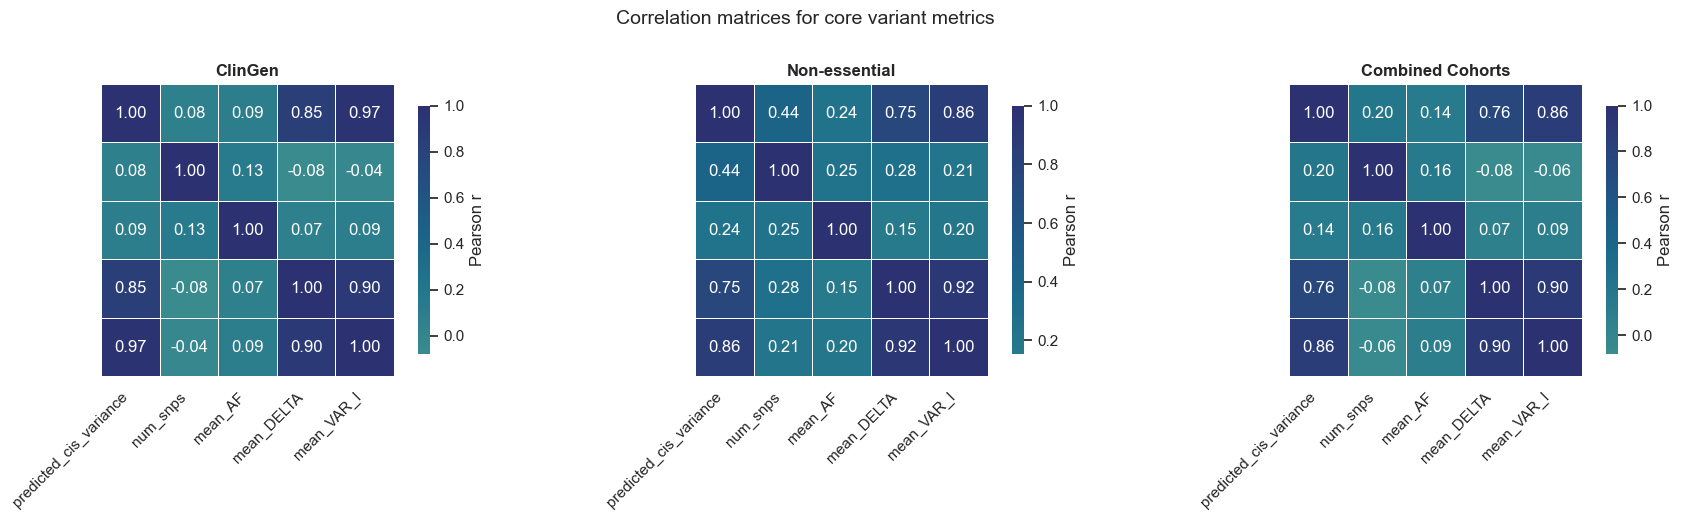

In [38]:
sns.set_theme(style="white")

core_cols = [
    "predicted_cis_variance",
    "num_snps",
    "mean_AF",
    "mean_DELTA",
    "mean_VAR_I"
]

def corr_heatmap(df: pd.DataFrame, title: str, ax=None):
    """
    Compute Pearson correlation matrix for *core_cols* in *df*
    and draw a seaborn heat-map on *ax* (or a new one if None).
    Returns the correlation DataFrame.
    """
    corr = df[core_cols].corr(method="pearson")
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(
        corr, annot=True, fmt=".2f", cmap="crest", center=0,
        linewidths=0.5, square=True, cbar_kws={"shrink": 0.85, "label": "Pearson r"},
        ax=ax
    )
    ax.set_title(title, fontsize=12, weight="bold")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    return corr

# ──-─  Build the three matrices in one figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

corr_clingen      = corr_heatmap(var_df_clingen,      "ClinGen",            ax=axes[0])
corr_nonessential = corr_heatmap(var_df_nonessential, "Non-essential",      ax=axes[1])
corr_combined     = corr_heatmap(var_df_all,          "Combined Cohorts",   ax=axes[2])

fig.suptitle("Correlation matrices for core variant metrics", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

# Keep the results handy if needed later
corr_matrices = {
    "ClinGen": corr_clingen,
    "Non-essential": corr_nonessential,
    "Combined": corr_combined
}

### 4.2 Partial correlation Analysis

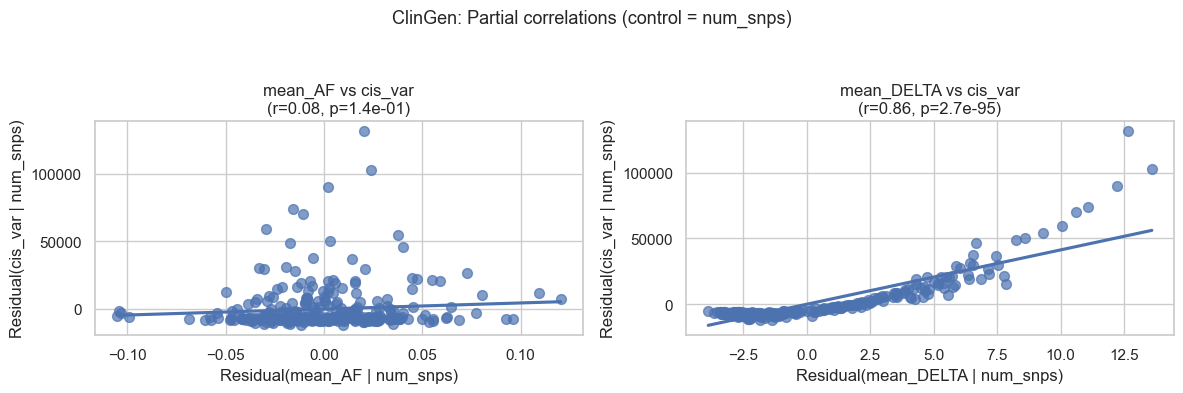

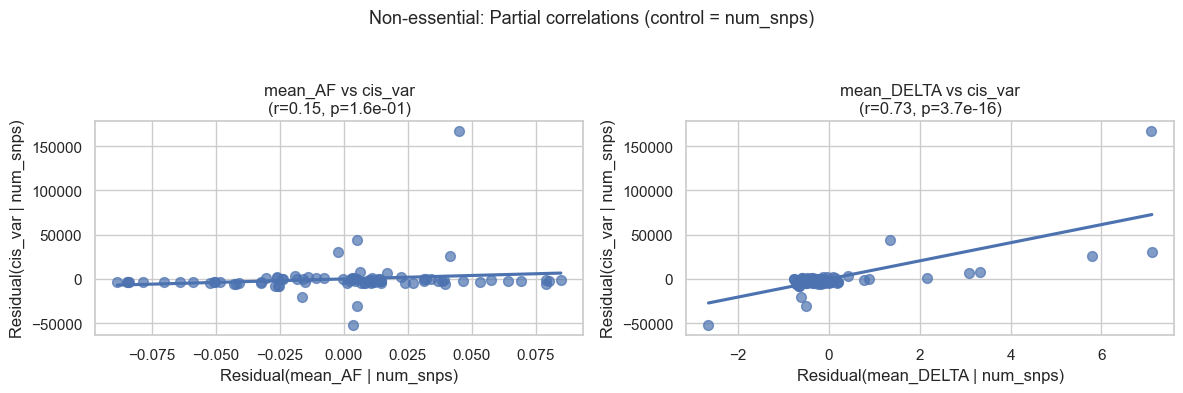

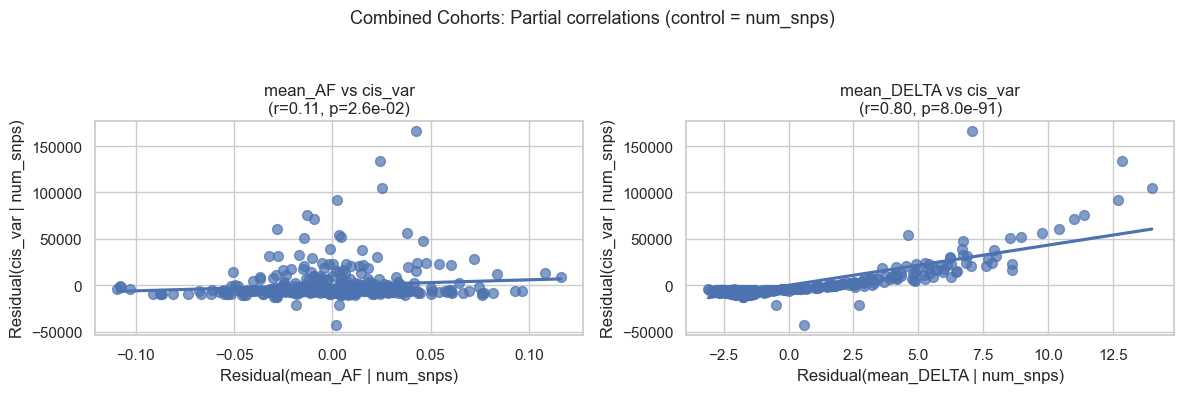


Partial correlation summary across cohorts:

             Cohort           X        Y   Control  Partial_Pearson_r  \
0           ClinGen     mean_AF  cis_var  num_snps              0.084   
1           ClinGen  mean_DELTA  cis_var  num_snps              0.865   
2     Non-essential     mean_AF  cis_var  num_snps              0.150   
3     Non-essential  mean_DELTA  cis_var  num_snps              0.729   
4  Combined Cohorts     mean_AF  cis_var  num_snps              0.111   
5  Combined Cohorts  mean_DELTA  cis_var  num_snps              0.799   

   Partial_Pearson_p  
0              0.138  
1              0.000  
2              0.158  
3              0.000  
4              0.026  
5              0.000  


In [39]:
sns.set_theme(style="whitegrid")

for _df in (var_df_clingen, var_df_nonessential, var_df_all):
    _df["cis_var"] = _df["predicted_cis_variance"]

def partial_corr(x, y, control, method="pearson"):
    """
    Returns r, p, residuals(x|control), residuals(y|control)
    """
    X = sm.add_constant(control)
    resid_x = sm.OLS(x, X).fit().resid
    resid_y = sm.OLS(y, X).fit().resid
    if method == "pearson":
        r, p = pearsonr(resid_x, resid_y)
    elif method == "spearman":
        r, p = spearmanr(resid_x, resid_y)
    else:
        raise ValueError("method must be 'pearson' or 'spearman'")
    return r, p, resid_x, resid_y


def partial_corr_overview(df, cohort_name,
                          features=("mean_AF", "mean_DELTA"),
                          control_col="num_snps"):
    """
    Draws residual-vs-residual plots and returns a summary DF of r & p.
    """
    results = []
    fig, axes = plt.subplots(1, len(features),
                             figsize=(6 * len(features), 4),
                             sharex=False, sharey=False)

    if len(features) == 1:
        axes = [axes]

    for i, feat in enumerate(features):
        r, p, res_x, res_y = partial_corr(df["cis_var"],
                                          df[feat],
                                          df[control_col])
        # store stats
        results.append(dict(
            Cohort=cohort_name,
            X=feat,
            Y="cis_var",
            Control=control_col,
            Partial_Pearson_r=r,
            Partial_Pearson_p=p
        ))

        sns.regplot(x=res_y, y=res_x, ci=None,
                    scatter_kws={"s": 50, "alpha": 0.7},
                    ax=axes[i])
        axes[i].set_xlabel(f"Residual({feat} | {control_col})")
        axes[i].set_ylabel("Residual(cis_var | num_snps)")
        axes[i].set_title(f"{feat} vs cis_var\n(r={r:.2f}, p={p:.1e})")

    fig.suptitle(f"{cohort_name}: Partial correlations (control = {control_col})",
                 fontsize=13)
    fig.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

    return pd.DataFrame(results)


partial_results = {}
for _df, _name in [
    (var_df_clingen,      "ClinGen"),
    (var_df_nonessential, "Non-essential"),
    (var_df_all,          "Combined Cohorts")
]:
    partial_results[_name] = partial_corr_overview(_df, _name)

partial_summary = pd.concat(partial_results.values(), ignore_index=True)
print("\nPartial correlation summary across cohorts:\n")
print(partial_summary.round(3))

- After removing the effect of num_snps, mean allele frequency has no remaining relationship to predicted cis-variance, so variant freq alone doesn’t explain expression variability — their contribution to cis-variance depends on effect size

- After accounting for num_snps, the strength of predicted regulatory effect (delta) is highly predictive of cis-variance. The more negative the average Δ across SNPs near a gene, the larger the predicted variance in expression.

## VGH gene metrics

Variance explained by Genetic factors in Humans - GTEx metric: the fraction of expression variance for a gene that is attributable to common cis variants across tissues. Higher VGH means that gene is tolerant to regulatory perturbation. We are using it in to see if genes that tolerate dosage swings also show higher predicted variance.

Loaded VGH: (26760, 17)

ClinGen:  merged N = 313
  Pearson  r = -0.113  p = 4.61e-02
  Spearman r = -0.087  p = 1.23e-01

Non-essential:  merged N = 51
  Pearson  r = 0.006  p = 9.69e-01
  Spearman r = 0.155  p = 2.78e-01

Combined:  merged N = 364
  Pearson  r = -0.005  p = 9.30e-01
  Spearman r = -0.131  p = 1.22e-02


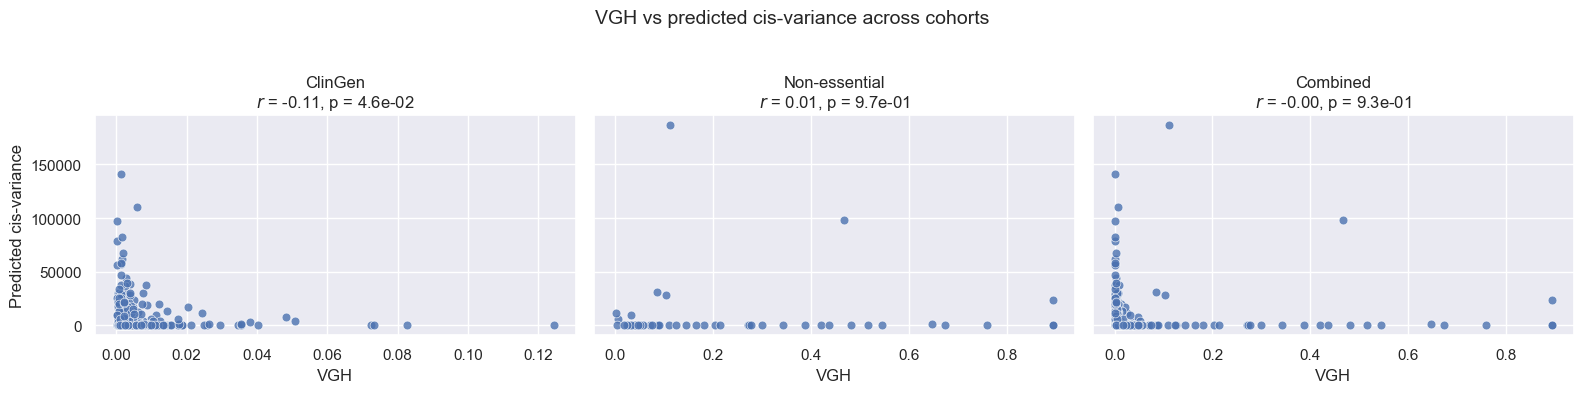

In [50]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

vgh = (pd.read_csv(gene_metrics_vgh, sep="\t", index_col=0)
         .reset_index()
         .rename(columns={"index": "gene_id"}))

vgh["gene_base"] = vgh["gene_id"].str.replace(r"\.\d+$", "", regex=True)
print("Loaded VGH:", vgh.shape)

# sanity
required_cols = {"gene_base", "vgh"}
assert required_cols.issubset(vgh.columns), \
    f"VGH file missing {required_cols - set(vgh.columns)}"

def merge_and_stats(var_df, cohort_label):
    if "gene_base" not in var_df.columns:
        var_df = var_df.assign(
            gene_base=var_df["gene_id"].str.replace(r"\.\d+$", "", regex=True)
        )
    df = (pd.merge(var_df, vgh, on="gene_base", how="inner")
            .dropna(subset=["vgh", "predicted_cis_variance"]))

    prs, p_p = pearsonr(df["vgh"], df["predicted_cis_variance"])
    spr, p_s = spearmanr(df["vgh"], df["predicted_cis_variance"])

    print(f"\n{cohort_label}:  merged N = {len(df)}")
    print(f"  Pearson  r = {prs:.3f}  p = {p_p:.2e}")
    print(f"  Spearman r = {spr:.3f}  p = {p_s:.2e}")
    return df, prs, p_p

cohort_dfs = {}
for lbl, df in [("ClinGen", var_df_clingen),
                ("Non-essential", var_df_nonessential),
                ("Combined", var_df_all)]:
    cohort_dfs[lbl] = merge_and_stats(df, lbl)[0]

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
for ax, (lbl, mdf) in zip(axes, cohort_dfs.items()):
    sns.scatterplot(data=mdf, x="vgh", y="predicted_cis_variance",
                    s=40, alpha=0.8, ax=ax)
    r, p = pearsonr(mdf["vgh"], mdf["predicted_cis_variance"])
    ax.set_title(f"{lbl}\n$r$ = {r:.2f}, p = {p:.1e}")
    ax.set_xlabel("VGH")
    ax.set_ylabel("Predicted cis-variance" if ax is axes[0] else "")

fig.suptitle("VGH vs predicted cis-variance across cohorts", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Summary

Clingen haplo-insufficient (HI) genes
- predicted cis-variance is higher but tiny (Cohen d = 0.18, Cliff δ = 0.10).
- Effect survives rank tests (MW-U p ≈ 10⁻⁵) only because n=314 SNP-filtered genes still gives power; practical impact is insignificant.

Non-essential genes
- carry less predicted cis-regulatory variance